In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_probability as tfp
import pandas_datareader as web
from keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import math
from tensorflow.keras.layers import LSTM, Dense

Import some data using pandas_datareader. Importing bitcoin data

In [ ]:
df1 = web.DataReader("BTC-USD", data_source='yahoo', start='2008-01-01', end='2020-12-30')
df1.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-16,468.174011,452.421997,465.864014,457.334015,21056800,457.334015
2014-09-17,456.859985,413.104004,456.859985,424.440002,34483200,424.440002
2014-09-18,427.834991,384.532013,424.102997,394.795990,37919700,394.795990
2014-09-19,423.295990,389.882996,394.673004,408.903992,36863600,408.903992
2014-09-20,412.425995,393.181000,408.084991,398.821014,26580100,398.821014


In [ ]:
df1.shape

(2298, 6)

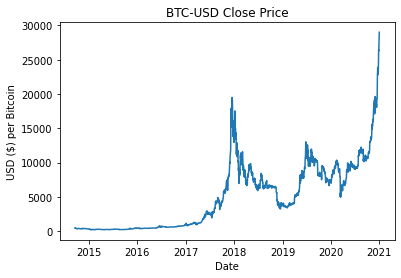

In [ ]:
plt.plot(df1.loc[:, "Close"])
plt.title("BTC-USD Close Price")
plt.xlabel("Date")
plt.ylabel('USD ($) per Bitcoin')
plt.show()


Split the data and convert to numpy arrays

Scale the data

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df_scale = scaler.fit_transform(df1)

In [ ]:
scaled_df = pd.DataFrame(df_scale, columns=['High', 'Low', 	'Open', 'Close', 'Volume',	'Adj Close'])
scaled_df

,High,Low,Open,Close,Volume,Adj Close
0,0.008833,0.010022,0.010081,0.009688,0.000204,0.009688
1,0.008443,0.008619,0.009767,0.008546,0.000385,0.008546
2,0.007443,0.007600,0.008624,0.007518,0.000432,0.007518
3,0.007287,0.007791,0.007597,0.008007,0.000417,0.008007
4,0.006913,0.007908,0.008065,0.007658,0.000279,0.007658
...,...,...,...,...,...,...
2293,0.967071,0.918688,0.916196,0.905306,0.896469,0.905306
2294,0.936081,0.928851,0.910665,0.933495,0.661500,0.933495
2295,0.935448,0.920990,0.938609,0.943127,0.610378,0.943127
2296,0.989421,0.969965,0.948317,0.994422,0.691584,0.994422


In [ ]:
y=scaled_df["Close"]
x = scaled_df[["High", "Low", "Open", "Volume", "Adj Close"]]

When we think about how we would predict a value from a list or history of values, we need to specify a window of values (features) that will contribute to the output value (target). Each day that window will move forward one value and the prediction will move along as well. But how would we validate the accuracy of such a model? We have to create a train test split, and create the window values for that period. Then we get it to predict the values, and measure the accuracy. First we have to split the data into training and testing sets. Then create a function to iterate through the sets, and collect the input window values, and the target output values.

In [ ]:
# Create the rolling window function
def rolling_window(input_series, window_size=25):
  features = []
  target = []
  series_len = len(input_series)
  for index, item in enumerate(input_series):
    if index < series_len - (window_size +1):
      win_start = index
      win_stop = index + window_size
      target_val = win_stop + 1
      features.append(np.array(input_series[win_start:win_stop]).reshape(-1, 1))
      target.append(np.array(input_series[target_val]))
  return np.array(features), np.array(target).reshape(-1, 1)



Split the data into training and testing 

In [ ]:
def split_data(data, test_size = 0.2):
  length = len(data)
  size = math.ceil(length*(1-test_size))
  training = data[:size]
  test = data[size:]
  return training, test


Split our scaled data and process the rolling window function for both datasets

In [ ]:
training, testing = split_data(y)
testing.reset_index(drop=True, inplace=True)
testing

0      0.281567
1      0.283281
2      0.285007
3      0.280391
4      0.278516
         ...   
454    0.905306
455    0.933495
456    0.943127
457    0.994422
458    1.000000
Name: Close, Length: 459, dtype: float64

In [ ]:
x_train, y_train = rolling_window(training, window_size = 60)
x_test, y_test = rolling_window(testing, window_size=60)

Check sizes of training and testing data. LSTM Model requires the x data to be 3D. Since there is only 1 output feature the target data will be 1D.



In [ ]:
print(x_train.shape, len(y_train))
print(x_test.shape, len(y_test))

(1778, 60, 1) 1778
(398, 60, 1) 398


Build the model

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(x_train, y_train, batch_size=5, epochs=5)

Epoch 1/5
356/356 [==============================] - 18s 41ms/step - loss: 0.0014
Epoch 2/5
356/356 [==============================] - 14s 41ms/step - loss: 5.8146e-04
Epoch 3/5
356/356 [==============================] - 14s 40ms/step - loss: 4.5015e-04
Epoch 4/5
356/356 [==============================] - 14s 40ms/step - loss: 4.3346e-04
Epoch 5/5
356/356 [==============================] - 15s 41ms/step - loss: 3.3775e-04


In [ ]:
preds = model.predict(x_test)

Now we can visualise the prediction vs the actual values. But first we must un-scale the data. We can use the scaler that we created to scale the data. But initially we scaled a dataframe of 6 columns, so to reverse the scaling im going to add the pred series to the original scaled_df and remove the original close column to invert the scaling.

In [ ]:
pred_reshape = pd.Series(preds.reshape(1, -1)[0], name="LSTM Prediction")
df_len = len(pred_reshape)
df_len = df_len*-1
pred_scale_df = scaled_df[['High', 'Low', 	'Open', 'Volume',	'Adj Close']]
pred_scale_df = pred_scale_df.iloc[df_len:, :]
pred_scale_df.reset_index(drop=True, inplace=True)
pred_incl = pd.concat([pred_scale_df, pred_reshape], axis=1)
pred_incl.shape


(398, 6)

now invert the scaling

In [ ]:
pred_array = scaler.inverse_transform(pred_incl)
pred_df = pd.DataFrame(pred_array, columns = ['High', 'Low', 	'Open', 'Volume',	'Adj Close', "Predictions"])


Now grab the original y_test values

In [ ]:
true_val_test = df1.iloc[df_len:, 3]
true_val_test.shape


(398,)

now combine into a df and visualise the data

In [ ]:
predict = pred_df.loc[:, "Predictions"]
predict.index = true_val_test.index
testing_df = pd.concat([true_val_test, predict], axis=1, sort=True)
testing_df.head()

,Close,Predictions
Date,,
2019-11-30,7569.629883,6844.638441
2019-12-01,7424.292480,7011.327758
2019-12-02,7321.988281,7061.177011
2019-12-03,7320.145508,7007.223405
2019-12-04,7252.034668,6904.581499


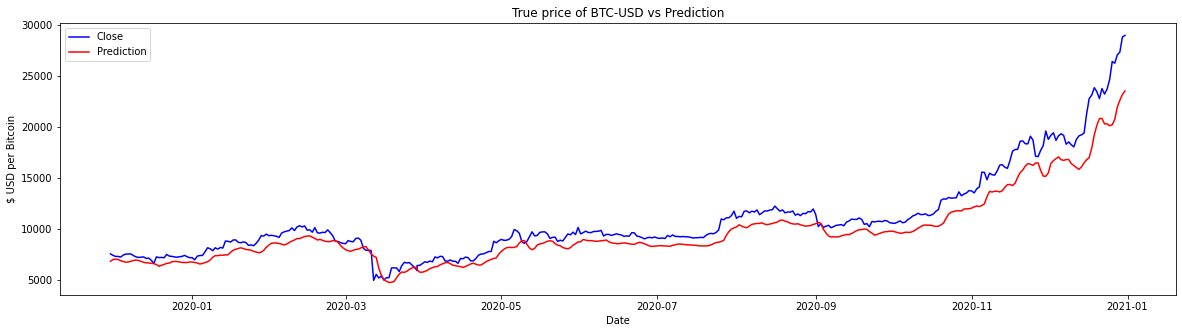

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(testing_df.loc[:, "Close"], color='blue', label="Close")
plt.plot(testing_df.loc[:, "Predictions"], color= 'red', label="Prediction")
plt.title("True price of BTC-USD vs Prediction")
plt.ylabel("$ USD per Bitcoin")
plt.xlabel("Date")
plt.legend()
plt.show()

But this doesnt provide a quantitative measure of the accuracy. Root mean squared error (RMSE) is commonly used as a metric for understanding the distance between the true value and an estimation. RMSE is the average of the distance from the predicted value, to the true value, and squared to remove negative values, and rooted to negate the square.

In [ ]:
testing_df["Difference"] = testing_df["Predictions"] - testing_df["Close"]
mean_error = np.mean(testing_df["Difference"])
squared_mean_error = mean_error*mean_error
rmse = np.sqrt(squared_mean_error)
rmse

1170.931843222932

So the average error we can expect is around $520 USD per obersavation. So probably not awesome enough to invest lots of money, yet. Just to see how that equates to the share price we can take that as a proportion of the final observation.

In [ ]:
final_price = testing_df.iloc[-1, 0]
final_price

29001.720703125

In [ ]:
proportion_error = rmse/final_price*100
print(f"Proportion Error: {proportion_error:.0f}%")

Proportion Error: 4%


So obviously this analysis only used a value window to predict the values up until today, because we wanted to check it against the known values. But given that the window size (n) only extends to one observation away from the end of the data, if we use the window size to the end of the dataset, that will effectively predict the next days value. So we can repeat the process quickly and predict tomorrows value +- the error.

In [ ]:
close_data = df1["Close"]
close_data

Date
2014-09-16      457.334015
2014-09-17      424.440002
2014-09-18      394.795990
2014-09-19      408.903992
2014-09-20      398.821014
                  ...     
2020-12-27    26272.294922
2020-12-28    27084.808594
2020-12-29    27362.437500
2020-12-30    28840.953125
2020-12-31    29001.720703
Name: Close, Length: 2298, dtype: float64

In [ ]:
close_data = np.array(close_data).reshape(-1, 1)
scaler2 = MinMaxScaler(feature_range=(0,1))
scaled_close = scaler2.fit_transform(close_data)
scaled_close

array([[0.00968758],
       [0.00854636],
       [0.0075179 ],
       ...,
       [0.94312708],
       [0.99442237],
       [1.        ]])

In [ ]:
last_sixty_vals = scaled_close[-60:]
next_pred = np.array(last_sixty_vals).reshape(1, 60, -1) #reshape to correct config for model interpretation, model expects 3D data
next_pred.shape

(1, 60, 1)

In [ ]:
tomorrow_scaled = model.predict(next_pred)
tomorrow_scaled

array([[0.85417825]], dtype=float32)

In [ ]:
inv_convert = scaler2.inverse_transform(tomorrow_scaled)
inv_convert


array([[24798.611]], dtype=float32)

Now compare to the last predicted value to see the trend.


In [ ]:
last_pred = testing_df.iloc[-1, 1]
last_pred

23545.99226136743

In [ ]:
delta_val = inv_convert - last_pred
delta_val

array([[1252.6191]], dtype=float32)

So the model predicts that the price will go up ~1000 in the next observation (however long that is).

Theoretically you can create endless datasets for prediction/forecasting any amount of time into the future. By adding the prediction to the existing dataset, you can create another x value dataset from which the model can predict. But model inaccuracies mean that the further the forecast, and the greater the error, the more likely it will be incorrect. The only way to minimise this is to ensure a minimal forecasting window, and continuously updating the true values and retraining the model. We we create a function to forecast future values.

In [ ]:
def prediction_function(model, data, window_size=25, n_forecast_days=7):
  functional_window = window_size*-1    #changes window size to be used for negative indexing
  forecast_index = n_forecast_days*-1   #changes window to negative so it can be used for indexing
  features = data[functional_window:].reshape(1, window_size, -1)
  for num in range(1, n_forecast_days+1):   #iteration of rolling for number of forecast days
    predicted_val = model.predict(features) # use the model to predict
    features.flatten()                           #flatten the array so the predicted value can be appended
    features = np.append(features, predicted_val)   #append predicted value
    features = np.delete(features, 0)             #delete the first value
    features = features.reshape(1, window_size, -1)  #reshape to use again in the iteration
  return features.flatten()[forecast_index:]             #return only the predicted values


In [ ]:
continuous_predictions = prediction_function(model, y_test, window_size=60, n_forecast_days=10)
full_pred_set = np.append(preds, continuous_predictions) 

Now we can visualise the predictions

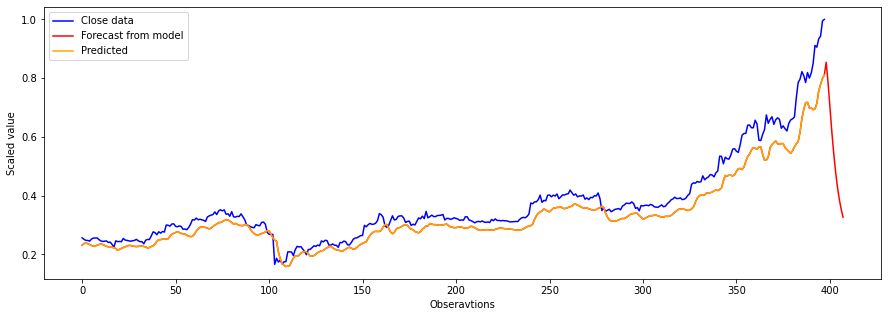

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y_test, color='blue', label="Close data")
plt.plot(full_pred_set, color='red', label="Forecast from model")
plt.plot(preds, color="orange", label="Predicted")
plt.ylabel("Scaled value")
plt.xlabel("Obseravtions")
plt.legend()
plt.show()

This shows that recurring prediction amplifies the error, causing the forecast to actually predict a sharp drop. This is because the model under predicts the value. Given that every time we add a value to the dataset by forecasting, it under estimates the value, which is then compounded the next time we use the dataset to predict from the model. In this instance we can see that the under-estimated prediction causes a significant drop in forecasted value. If it happened that we over predicted the close price with the model, we could expect a sharp rise in value with increased forecasting.